This notebook is the glue between this repo and https://github.com/sirfoga/minGPT:

- prepares data to be used by minGPT
- some other stuff

In [123]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

In [115]:
from attila.util.config import get_env
from attila.data.parse import parse_data, get_data
from attila.util.plots import plot_history, plot_preds, get_figa
from attila.data.transform import normalize_transformation
from attila.util.io import load_json, stuff2pickle

In [4]:
_here = Path('.').resolve()

In [6]:
config, data_path, out_path, models_config_path = get_env(_here)
images_path = data_path / config.get('data', 'images')
masks_path = data_path / config.get('data', 'masks')

In [64]:
raw = get_data(images_path, masks_path)  # (list of imgs, list of corresponding mask)
X, y = parse_data(raw)

In [137]:
from skimage.transform import resize

def extract_patches(X, y=None, crop_size=128, resize_size=32, samples_per_img=16):
    n_images = X.shape[0]
    crop_height = crop_size  # todo square
    crop_width = crop_size
    resize_height = resize_size  # todo square
    resize_width = resize_size
    out_shape = (samples_per_img * n_images, crop_width, crop_height, 1)  # grayscale images and mask
    Xp, yp = [], []
    
    if y is None:
        y = [ None ] * len(X)

    for _, (img, mask) in enumerate(zip(X, y)):
        for _sample in range(samples_per_img):   
            width_0 = np.random.randint(0, img.shape[1] - crop_width)
            width_1 = width_0 + crop_width

            height_0 = np.random.randint(0, img.shape[0] - crop_height)
            height_1 = height_0 + crop_height
            img_crop = img[height_0: height_1, width_0: width_1, ...]
            
            if mask:
                mask_crop = mask[height_0: height_1, width_0: width_1, ...]

                if np.sum(mask_crop.ravel()) > 0.5:  # there is a mask
                    Xp.append(resize(img_crop, (resize_height, resize_width)))
                    yp.append(resize(mask_crop, (resize_height, resize_width)))
            else:
                Xp.append(resize(img_crop, (resize_height, resize_width)))
        
    return np.array(Xp, dtype='float32'), np.array(yp, dtype='float32')

In [125]:
out = extract_patches(X, y)
print('X ~ {}, y ~ {}'.format(out[0].shape, out[1].shape))

X ~ (1413, 32, 32, 1), y ~ (1413, 32, 32, 1)


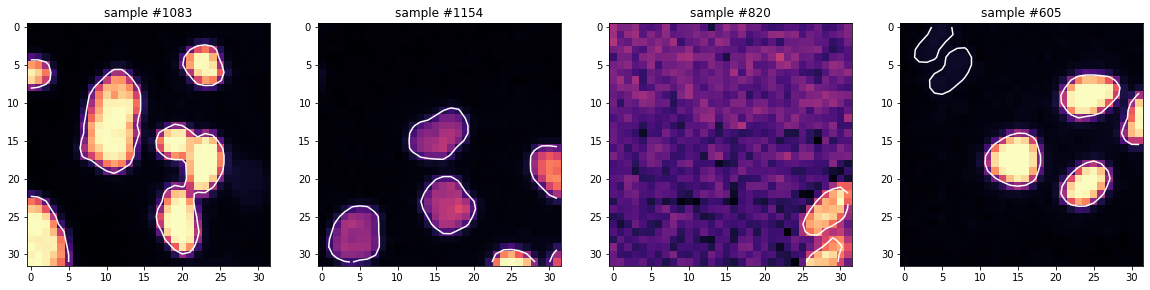

In [113]:
check_n = 4
fig, axis = get_figa(1, check_n)

for ax, i in zip(axis, np.random.randint(0, len(out[0]), size=check_n)):
    ax.imshow(out[0][i, :, :, 0], cmap='magma')
    ax.contour(out[1][i, :, :, 0], colors='white', levels=[0.5])
    ax.set_title('sample #{}'.format(i))

In [116]:
stuff2pickle(out, 'results/minGPT_data.pkl')

In [140]:
X, _ = get_data(Path('~/Scuola/now/rp/martin/minGPT/data/sampleA/').expanduser())
X = np.array(X, dtype='float32')
print('X ~', X.shape)

Xp, _ = extract_patches(X, crop_size=128, resize_size=32, samples_per_img=200)
print('patches ~', Xp.shape)

stuff2pickle(Xp, 'results/minGPT_brain_data.pkl')

 X~ (123, 1250, 1250)
patches ~ (24600, 32, 32)
